In [165]:
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats

import math as m
import statistics

import glob
import os, sys
print(" Danke für die Spielwiese :) ")

 Danke für die Spielwiese :) 


In [166]:
df = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
print(df.describe())
print(df.head())

       GesamtEnergie
count   18231.000000
mean        1.411104
std         7.264719
min         0.064903
25%         0.649634
50%         0.980337
75%         1.602746
max       842.714539
                        GesamtEnergie
 20220509_16_09_32.wav       0.259039
 20220509_16_09_35.wav     105.340950
 20220509_16_09_38.wav      45.166122
 20220509_16_09_41.wav      13.809454
 20220509_16_09_44.wav      39.506104


In [167]:
df_copy = df.copy()
#df_copy.applymap(lambda x: x/2**15, na_action='ignore')
print(df_copy.describe())

var = df_copy['GesamtEnergie'] / 2 ** 15
df_copy= df_copy.apply(lambda x: x/ 2**15,axis=1)
print(var)

print(df_copy.describe())

       GesamtEnergie
count   18231.000000
mean        1.411104
std         7.264719
min         0.064903
25%         0.649634
50%         0.980337
75%         1.602746
max       842.714539
 20220509_16_09_32.wav    0.000008
 20220509_16_09_35.wav    0.003215
 20220509_16_09_38.wav    0.001378
 20220509_16_09_41.wav    0.000421
 20220509_16_09_44.wav    0.001206
                            ...   
 20220510_09_28_13.wav    0.000021
 20220510_09_28_16.wav    0.000041
 20220510_09_28_19.wav    0.000014
 20220510_09_28_22.wav    0.000017
 20220510_09_28_25.wav    0.000020
Name: GesamtEnergie, Length: 18231, dtype: float64
       GesamtEnergie
count   18231.000000
mean        0.000043
std         0.000222
min         0.000002
25%         0.000020
50%         0.000030
75%         0.000049
max         0.025718


In [168]:
from main import prognose

print(prognose(df_copy))

Prognosewert: x <=	 GesamtEnergie    0.0004
dtype: float64 W
GesamtEnergie    0.000408
dtype: float64


C:\Users\mirko\anaconda3\envs\sixSigma\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


GesamtEnergie    0.025718
dtype: float64
GesamtEnergie    0.008312
dtype: float64


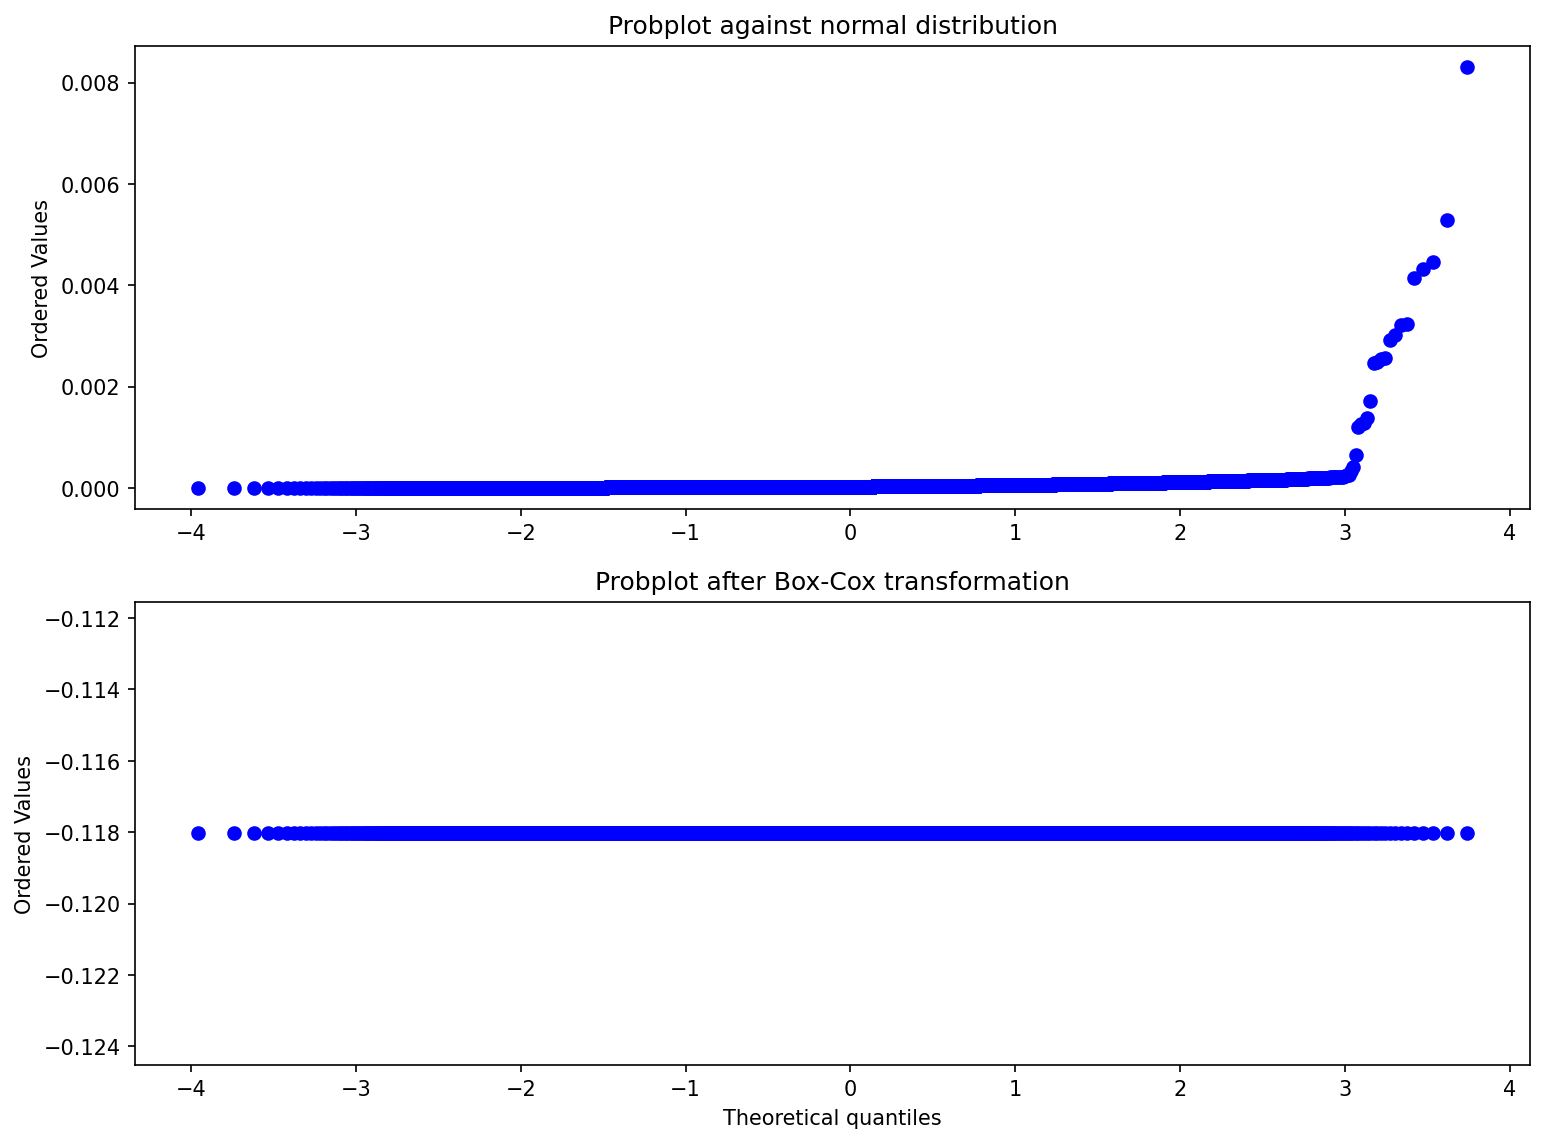

In [169]:
# df.loc['cobra'] = 10
m = df_copy > 0.02
print(df_copy.max())
df_copy.mask(m,other=np.nan, inplace=True)
print(df_copy.max())

In [171]:
from scipy import stats
def boxcox(df222):
    x = df222['GesamtEnergie']/2**15
    print(x.max())
    fig = plt.figure()

    ax1 = fig.add_subplot(211)
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')

    ax2 = fig.add_subplot(212)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)

    ax2.set_title('Probplot after Box-Cox transformation')

    plt.show()
    return xt

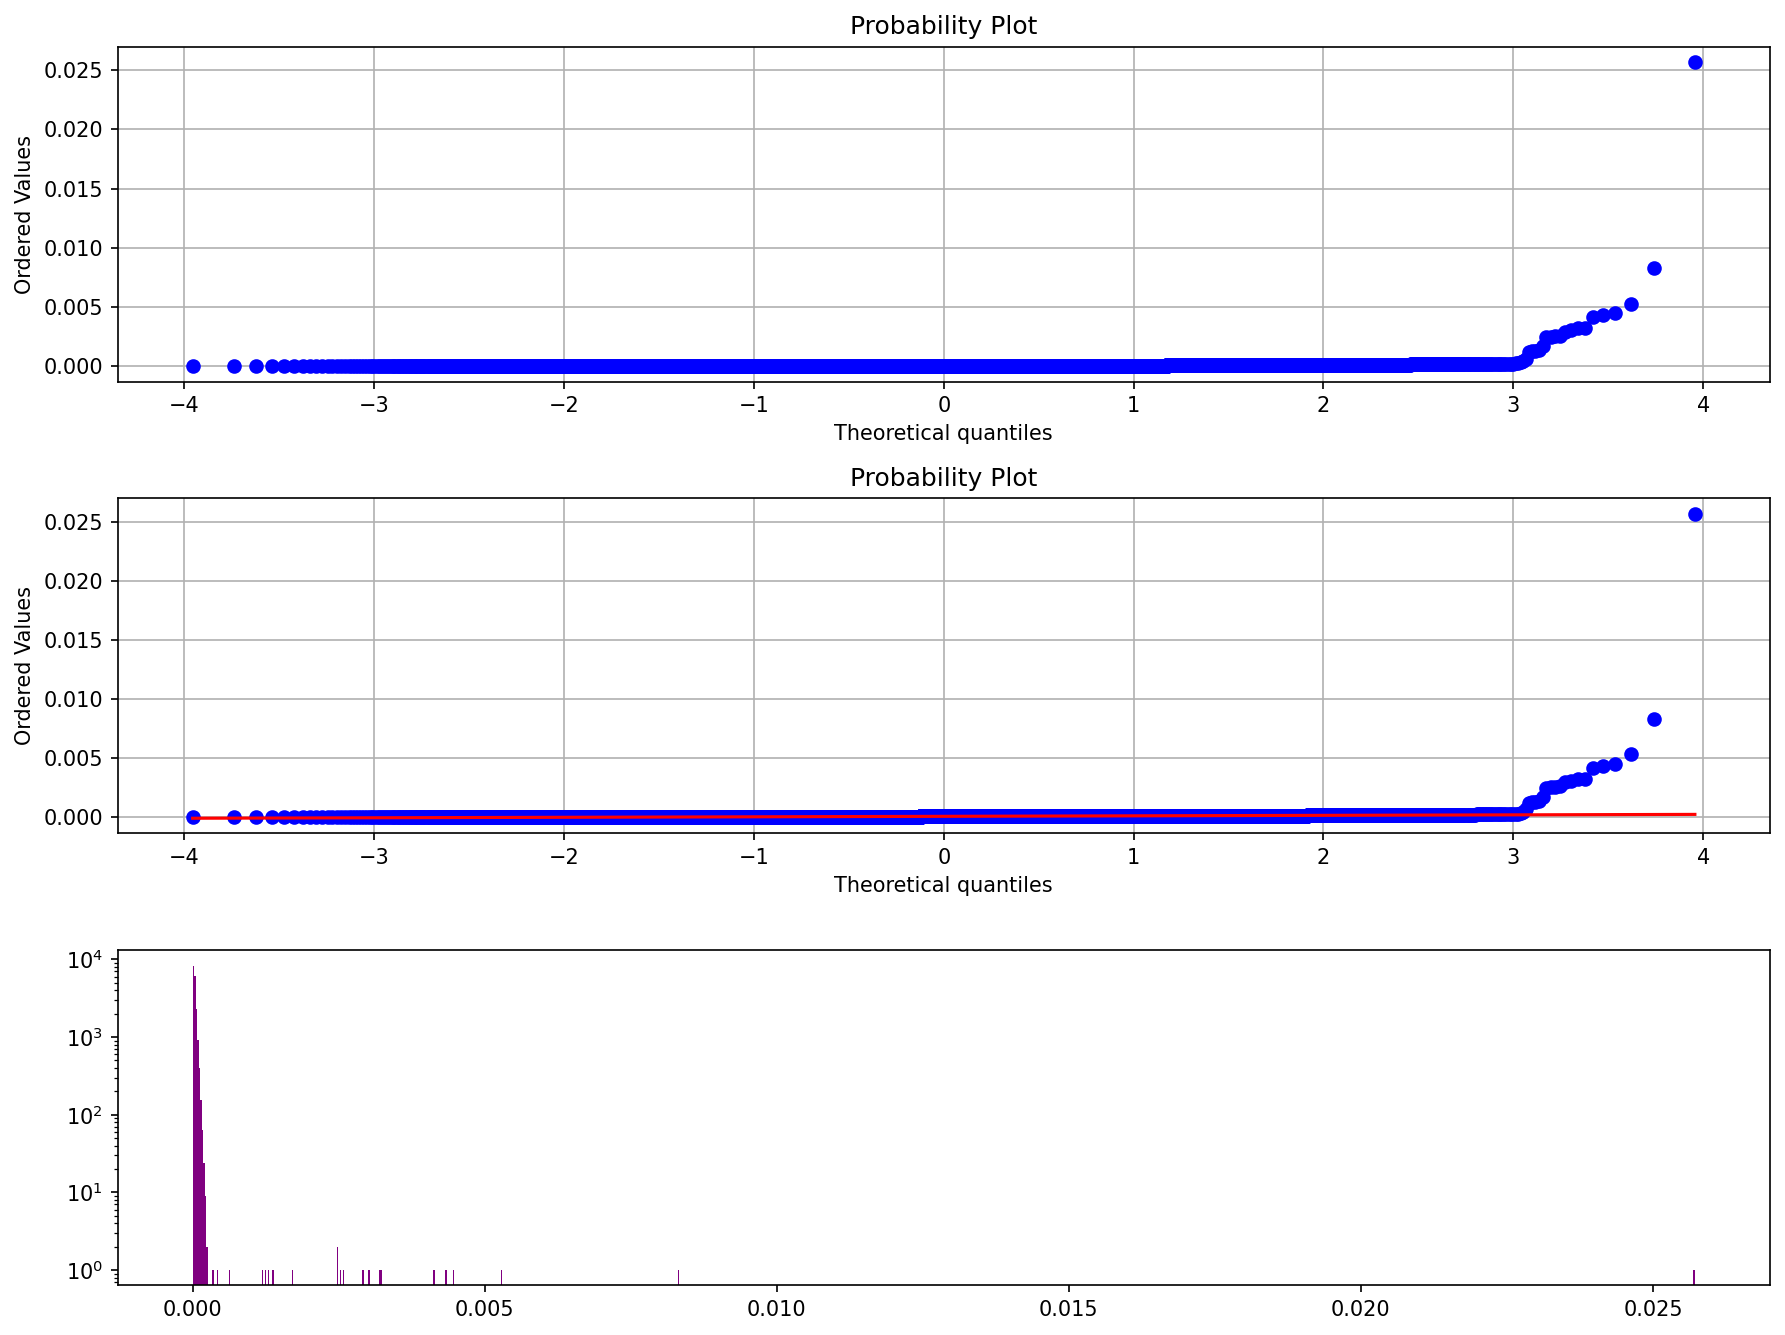

In [216]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1)#, sharey='all')

sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
pwr = sieb_energien['GesamtEnergie']/2**15

prob     = stats.probplot(pwr, dist=stats.norm, plot=ax1, fit=False)
prob_fit = stats.probplot(pwr, dist=stats.norm, plot=ax2, fit=True)

nrm = sieb_energien['GesamtEnergie']
pwr[:].hist(bins=1000, grid=True, color='purple',log=True)


# Plot verschönern
ax1.grid()
ax2.grid()
ax3.grid()

fig.tight_layout()
plt.show()

#sieb_energien.plot.hist()

Prognosewert: x <=	 21.3759 W
0.025717606768012047


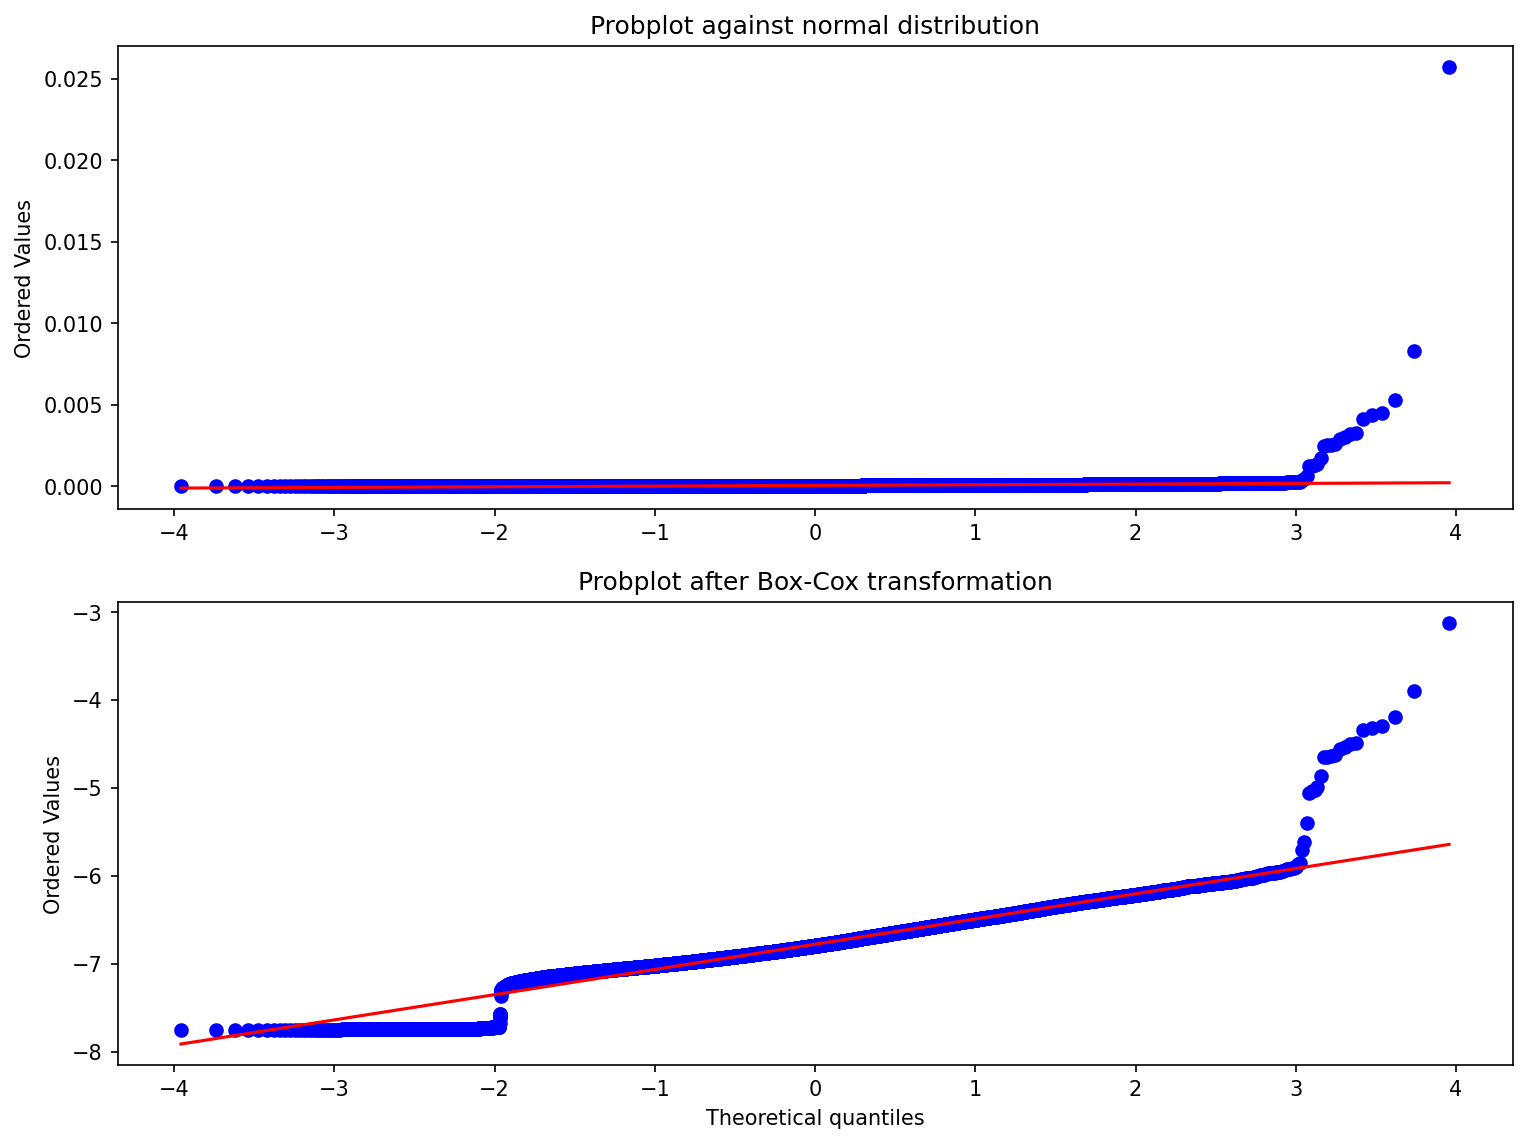

[-7.29355191 -4.49692456 -4.98693355 ... -7.08754447 -7.00784193
 -6.95806369]


In [218]:
######################
# Erstmal siebe ich die extremen Ausreißer mit einer weitem Prognosebereich aus
######################
progmax = prognose(sieb_energien[["GesamtEnergie"]].to_numpy(),gamma=0.997)
boxx = boxcox(sieb_energien)
print(boxx)

In [219]:
idx = 0
while idx < 2:
    sieb_energien = sieb_energien.dropna()
    # Die Prognose darf nicht mit allen Daten gespeist werden, es muss eine !gute! Stichprobe sein
    if idx<1:
        progmax = prognose(sieb_energien[["GesamtEnergie"]].to_numpy(),gamma=0.997)

    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in sieb_energien.index:
        if sieb_energien.loc[x, "GesamtEnergie"] > progmax:
            sieb_energien.drop(x, inplace=True)
    idx += 1
    print(sieb_energien.shape[0])

sieb_energien.to_csv('sieb.csv', index=True)
wavfiles = sieb_energien.index.values

Prognosewert: x <=	 21.3759 W
18212
18212


In [175]:
from datetime import datetime
from enum import Enum
class ZeigerWinkel(Enum):
    HOCH = 1
    RUNTER = 2
    UNSICHER1 = 3
    UNSICHER2 = 4

form = r' %Y%m%d_%H_%M_%S'
print('Hello ')
dt_list = []
for row_index,row in sieb_energien.iterrows():
    #dat = os.path.splitext(row_index)[0]
    dat = os.path.basename(row_index)
    dat = dat.split(".")[0]
    date_string = datetime.strptime(dat,form)
    sekzeiger = date_string.second
    status = "'"
    try:
        if not sekzeiger <= 0 and sekzeiger < 3:
            status = ZeigerWinkel(3)
        if not sekzeiger <= 3 and sekzeiger < 27:
            status = ZeigerWinkel(2)
        if not sekzeiger <= 27 and sekzeiger < 33:
            status = ZeigerWinkel(4)
        if not sekzeiger <= 33 and sekzeiger < 57:
            status = ZeigerWinkel(2)
        if not sekzeiger <= 57 and sekzeiger < 0:
            status = ZeigerWinkel(3)
    except:
        pass
    dt_list.append((date_string, status ))


dtdf  = pandas.DataFrame(dt_list,index=sieb_energien.index, columns=['rectime', 'ZeigerWinkel'])
dtdf.head()

Hello 


,rectime,ZeigerWinkel
20220509_16_09_32.wav,2022-05-09 16:09:32,ZeigerWinkel.UNSICHER2
20220509_16_09_41.wav,2022-05-09 16:09:41,ZeigerWinkel.RUNTER
20220509_16_09_47.wav,2022-05-09 16:09:47,ZeigerWinkel.RUNTER
20220509_16_09_56.wav,2022-05-09 16:09:56,ZeigerWinkel.RUNTER
20220509_16_10_04.wav,2022-05-09 16:10:04,ZeigerWinkel.RUNTER


In [176]:
df1 = sieb_energien.copy()/2**15
df2 = dtdf.copy()

df2.head()

,rectime,ZeigerWinkel
20220509_16_09_32.wav,2022-05-09 16:09:32,ZeigerWinkel.UNSICHER2
20220509_16_09_41.wav,2022-05-09 16:09:41,ZeigerWinkel.RUNTER
20220509_16_09_47.wav,2022-05-09 16:09:47,ZeigerWinkel.RUNTER
20220509_16_09_56.wav,2022-05-09 16:09:56,ZeigerWinkel.RUNTER
20220509_16_10_04.wav,2022-05-09 16:10:04,ZeigerWinkel.RUNTER


In [177]:
#df3 = df1.merge(df2, left_on=df1.index, right_on=[0])
df3 = df1.join(df2)
print(df3)

                        GesamtEnergie             rectime  \
 20220509_16_09_32.wav       0.000008 2022-05-09 16:09:32   
 20220509_16_09_41.wav       0.000421 2022-05-09 16:09:41   
 20220509_16_09_47.wav       0.000063 2022-05-09 16:09:47   
 20220509_16_09_56.wav       0.000160 2022-05-09 16:09:56   
 20220509_16_10_04.wav       0.000018 2022-05-09 16:10:04   
...                               ...                 ...   
 20220510_09_28_13.wav       0.000021 2022-05-10 09:28:13   
 20220510_09_28_16.wav       0.000041 2022-05-10 09:28:16   
 20220510_09_28_19.wav       0.000014 2022-05-10 09:28:19   
 20220510_09_28_22.wav       0.000017 2022-05-10 09:28:22   
 20220510_09_28_25.wav       0.000020 2022-05-10 09:28:25   

                                  ZeigerWinkel  
 20220509_16_09_32.wav  ZeigerWinkel.UNSICHER2  
 20220509_16_09_41.wav     ZeigerWinkel.RUNTER  
 20220509_16_09_47.wav     ZeigerWinkel.RUNTER  
 20220509_16_09_56.wav     ZeigerWinkel.RUNTER  
 20220509_16_10_04.wav